# loop the indexes to run the cross validation in such a way that one set is the validaion, one set is the test and the remaining tre are the training ones. 

In [1]:
#install the required packages and import the functions
! pip install import-ipynb
! pip install scikit-learn
import import_ipynb
from create_pswm import * #function that get the pswm
from validation_and_testing_vonheijne import * #function that creates the validation scores
import pandas as pd


testing set:  1
validation set:  2
training sets:  (3, 4, 5)
MCC = 0.6239795692339462
Precision = 0.9295071740486588
Accuracy = 0.6894409937888198
Sensitivity = 0.6379310344827587


testing set:  2
validation set:  3
training sets:  (4, 5, 1)
MCC = 0.6148907606147579
Precision = 0.9276356830941984
Accuracy = 0.6790123456790124
Sensitivity = 0.632183908045977


testing set:  3
validation set:  4
training sets:  (5, 1, 2)
MCC = 0.6987869204127577
Precision = 0.9469744229569557
Accuracy = 0.856
Sensitivity = 0.6149425287356322


testing set:  4
validation set:  5
training sets:  (1, 2, 3)
MCC = 0.6384524186414046
Precision = 0.933873986275733
Accuracy = 0.7266666666666667
Sensitivity = 0.6264367816091954


testing set:  5
validation set:  1
training sets:  (2, 3, 4)
MCC = 0.617964564181956
Precision = 0.9316345556246115
Accuracy = 0.753731343283582
Sensitivity = 0.5674157303370787




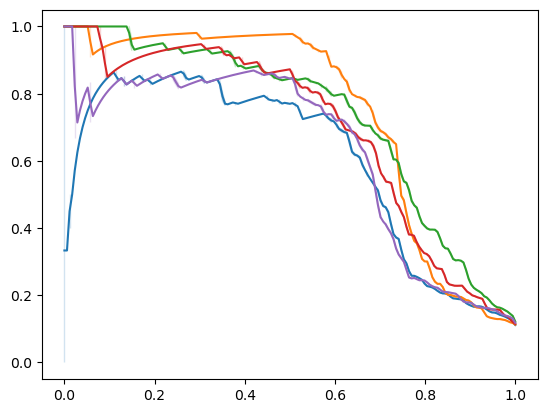

In [2]:
total = pd.read_csv("../Data_Preparation/train_bench.tsv", sep = "\t")
stats_list=[]
metrics_name = ["MCC", "Precision", "Accuracy", "Sensitivity"]
# 5-cross-validation run: for each run i, testing set=i, validation set=((i)%5)+1, training sets = remaining i sets
for i in range(1,6): 
    training_sets=((((i+1)%5)+1),(((i+2)%5)+1),(((i+3)%5)+1)) 
    testing = total.query(f"Set=='{i}'")
    validation = total.query(f"Set=='{((i)%5)+1}'")
    training = total.query(f"Class=='Positive' and (Set=='{training_sets[0]}' or Set=='{training_sets[1]}' or Set=='{training_sets[2]}')")
    print("testing set: ",i)
    print("validation set: ", ((i)%5)+1)
    print("training sets: ",training_sets)

    #Compute the respective iteration PSWM
    pswm=get_pswm(training,13,2)

    #Get the metrics for the i-th run (MCC, Precision, Accuracy, Sensitivity)
    stats=metrics(pswm, validation, testing)
    stats_list.append(stats)
    for name, stat in zip(metrics_name,stats):
        print(f"{name} = {stat}")
    print("\n")



    
   




    

In [3]:
#Convert the list of stats in an array to facilitate computations
stats_arr = np.array(stats_list)

#Made the mean of each characteristic (MCC, Precision, Accuracy, Sensitivity)
stats_means = np.mean(stats_arr, axis=0)

#Compute the standard deviation 
stats_stds = stats_arr.std(axis=0, ddof=1)          

#Compute the SE
ses = stats_stds / np.sqrt(stats_arr.shape[0])       

#define the metrics
metrics = ["MCC", "Precision", "Accuracy", "Sensitivity"]


for name, mean, se in zip(metrics, stats_means, ses):
    print(f"{name} = {mean:.3f} ± {se:.3f}")


MCC = 0.639 ± 0.016
Precision = 0.934 ± 0.003
Accuracy = 0.741 ± 0.032
Sensitivity = 0.616 ± 0.013
